In [1]:
using SparseArrays
using Krylov
using LinearAlgebra
using Random
using Plots
Random.seed!(1234);  # determinism

In [2]:
function ls_solve_qr(A::SparseMatrixCSC{Float64,Int64}, b::Vector{Float64})
    F = qr(Matrix(A))
    Q = Matrix(F.Q)
    R = Matrix(F.R)
    return R \ (Matrix(Q)' * b)
end
ls_solve_backslash(A::SparseMatrixCSC{Float64,Int64}, b::Vector{Float64}) = 
    A \ b
ls_solve_lsqr(A::SparseMatrixCSC{Float64,Int64}, b::Vector{Float64}, ϵ::Float64) =
    lsqr(A, b, etol=ϵ)[1]
ls_solve_lsmr(A::SparseMatrixCSC{Float64,Int64}, b::Vector{Float64}, ϵ::Float64) =
    lsmr(A, b, etol=ϵ)[1]

function time_algs(m::Int64, n::Int64; dryrun=false)
    sparsity = 0.1;
    A = sprand(m, n, sparsity);
    b = A * randn(n) + rand(m) * 1e-2;
    
    if dryrun
        ls_solve_backslash(A, b);  ls_solve_qr(A, b)
        ls_solve_lsqr(A, b, 1e-3); ls_solve_lsmr(A, b, 1e-3)
        return
    end
    
    println("Backslash operator...")
    @time ls_solve_backslash(A, b)
    println("QR...")
    @time ls_solve_qr(A, b)

    tol = 1e-6
    println("LSQR (tol=$tol)...")
    @time ls_solve_lsqr(A, b, tol)
    println("LSMR (tol=$tol)...")
    @time ls_solve_lsmr(A, b, tol)        
end

# warm up to compile
time_algs(1000, 100, dryrun=true)

# timing
time_algs(10000, 1000);

Backslash operator...
  0.970050 seconds (3.17 k allocations: 489.203 MiB, 23.87% gc time)
QR...
  1.387076 seconds (22 allocations: 328.630 MiB, 9.31% gc time)
LSQR (tol=1.0e-6)...
  0.045386 seconds (1.48 k allocations: 2.339 MiB)
LSMR (tol=1.0e-6)...
  0.044935 seconds (1.80 k allocations: 2.785 MiB)


In [3]:
time_algs(50000, 2000);

Backslash operator...
 15.649572 seconds (6.17 k allocations: 4.733 GiB, 2.57% gc time)
QR...
 26.614473 seconds (22 allocations: 3.071 GiB, 0.98% gc time)
LSQR (tol=1.0e-6)...
  0.599346 seconds (1.26 k allocations: 8.346 MiB)
LSMR (tol=1.0e-6)...
  0.559299 seconds (1.43 k allocations: 8.596 MiB)


In [4]:
time_algs(200000, 3000);

Backslash operator...
215.173337 seconds (9.18 k allocations: 28.294 GiB, 0.57% gc time)
QR...
300.975537 seconds (24 allocations: 18.084 GiB, 0.71% gc time)
LSQR (tol=1.0e-6)...
  7.339657 seconds (1.17 k allocations: 27.382 MiB, 13.19% gc time)
LSMR (tol=1.0e-6)...
  3.192098 seconds (1.44 k allocations: 28.349 MiB, 0.04% gc time)


In [5]:
m, n = 1000, 100
A = sprand(m, n, 0.2);
b = A * randn(n) + rand(m) * 1e-3;

lsqr_sol = lsqr(A, b, etol=1e-8)
lsmr_sol = lsmr(A, b, etol=1e-8)

([0.427297, -0.0493791, -0.603194, 0.280008, 0.0364618, 0.615627, -0.0662535, -0.28821, 0.468509, 0.696123  …  0.0277487, -1.86188, 2.03978, 0.982666, -0.354289, -0.65256, -0.753964, 1.63472, -0.602206, -0.686395], 
Simple stats
  solved: true
  inconsistent: true
  residuals:  [  6.6e+01  6.1e+01  1.9e+01 ...  9.2e-03  9.2e-03  9.2e-03 ]
  Aresiduals: [  6.7e+02  4.6e+02  1.3e+02 ...  9.8e-08  6.8e-08  2.0e-08 ]
  status: truncated forward error small enough
)

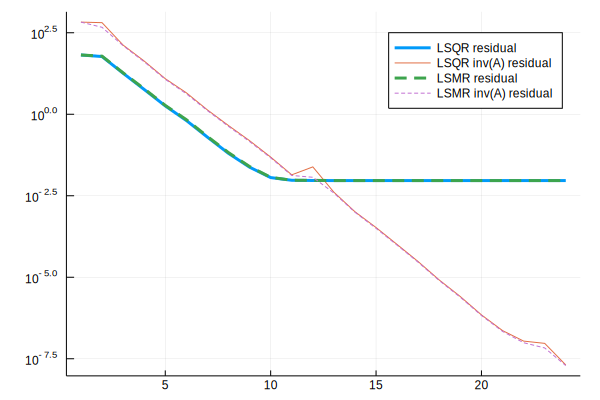

In [6]:
plot( lsqr_sol[2].residuals,  lw=3, label="LSQR residual")
plot!(lsqr_sol[2].Aresiduals, lw=1, label="LSQR inv(A) residual")
plot!(lsmr_sol[2].residuals,  lw=3, ls=:dash, label="LSMR residual")
plot!(lsmr_sol[2].Aresiduals, lw=1, ls=:dash, label="LSMR inv(A) residual", yscale=:log10)